# Making NBA Shot Charts

I've seen tons of <a href = 'https://www.reddit.com/r/nba/'>r/nba</a> shot charts images. So I wanted to learn how I can make one using python. In this notebook I'll detail my process and hopefully show some fun shot charts!

## Getting the Data

The first issue is how can I get the cool (x,y)-coordinate values to make my shot chart. I did some searching and found the following python library, <a href = 'https://github.com/swar/nba_api'>nba_api</a>, that seems super helpful for getting the NBA's readily available data. So I geared up to explore how I can get the data.

In [1]:
## First import the packages we'll be using
# For grabbing data
from nba_api.stats.static import players
from nba_api.stats.endpoints import shotchartdetail

# for handling data
import pandas as pd
import numpy as np

# for plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

# I got tired of seeing the seaborn warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
## First we'll find a particular player, let's say Kevin Durant
# Returns a dictionary of all NBA players
NBA_Players = players.get_players()

# Here we will select Kevin Durant from the dictionary
Kevin_Durant = [player for player in NBA_Players
                   if player['full_name'] == "Kevin Durant"][0]
print(Kevin_Durant)

KD_ID = Kevin_Durant['id']

{'first_name': 'Kevin', 'last_name': 'Durant', 'id': 201142, 'full_name': 'Kevin Durant'}


In [3]:
## Now we'll grab all of Kevin Durant's Taken Shots
KD_Shots = shotchartdetail.ShotChartDetail(player_id = KD_ID, team_id = 0, context_measure_simple = 'FGA')

# Store the data as a dataframe
KD_Shots_DF = KD_Shots.get_data_frames()[1]

In [4]:
# See the data!
KD_Shots_DF.head(5)

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0020700011,21,201142,Kevin Durant,1610612760,Seattle SuperSonics,1,10,0,...,Center(C),24+ ft.,26,-54,261,1,0,20071031,DEN,SEA
1,Shot Chart Detail,0020700011,36,201142,Kevin Durant,1610612760,Seattle SuperSonics,1,8,27,...,Center(C),8-16 ft.,9,13,94,1,0,20071031,DEN,SEA
2,Shot Chart Detail,0020700011,39,201142,Kevin Durant,1610612760,Seattle SuperSonics,1,8,14,...,Left Side(L),8-16 ft.,15,-149,51,1,0,20071031,DEN,SEA
3,Shot Chart Detail,0020700011,82,201142,Kevin Durant,1610612760,Seattle SuperSonics,1,4,31,...,Center(C),Less Than 8 ft.,0,0,0,1,1,20071031,DEN,SEA
4,Shot Chart Detail,0020700011,92,201142,Kevin Durant,1610612760,Seattle SuperSonics,1,3,11,...,Center(C),Less Than 8 ft.,0,0,0,1,0,20071031,DEN,SEA


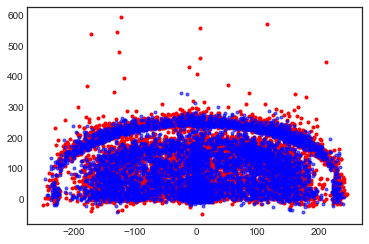

In [5]:
# We can even plot all of KD's shot attempts throughout his career
# Blue is a Make, Red is a Miss
Makes = KD_Shots_DF.loc[KD_Shots_DF.SHOT_MADE_FLAG == 1,['LOC_X','LOC_Y']]
Misses = KD_Shots_DF.loc[KD_Shots_DF.SHOT_MADE_FLAG == 0,['LOC_X','LOC_Y']]
plt.plot(Misses.LOC_X, Misses.LOC_Y, 'r.')
plt.plot(Makes.LOC_X, Makes.LOC_Y, 'b.', alpha = .6)
plt.show()



Somewhere in that chart is the dagger three that broke my heart in the 2017 NBA finals. :'(.

Something else that's sad is that our chart isn't as pretty, or as useful as other shot charts. We'll work on that in the next few sections.

## Making Pretty Charts

Did you read the previous section? Are you excited? You should be! We've got data now, all is good. Now that we have our data we'll work on making our shot charts. I'm particularly inspired to examine Durant's shots as a member of OKC compared to his shots with the Warriors. On the <a href = "https://www.youtube.com/watch?v=WLMB0130nCA">special sports rewatchables edition</a> of the Bill Simmons podcast Bill commented that Durant's iconic shots were his dagger threes (as a Cavs fan that attended Game 3 of the 2017 Finals, I'm biased to agree), and that the OKC offense didn't really open Durant up to these shots.

So eventually we'll work toward seeing whether or not Durant attempted/made more threes as a Warrior. For now let's just focus on making a prettier shot chart.

We'll use Kevin's rookie season for this first attempt.

In [6]:
# Find his Rookie Season
Rookie = KD_Shots = shotchartdetail.ShotChartDetail(player_id = KD_ID, team_id = 0, context_measure_simple = 'FGA',season_nullable = '2007-08')
Rookie_DF = Rookie.get_data_frames()[1]

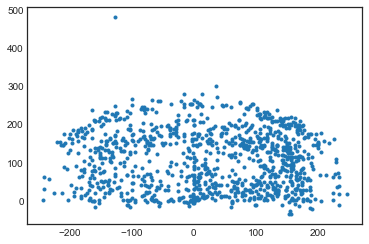

In [7]:
# Here's his not pretty rookie shot chart
plt.plot(Rookie_DF.LOC_X,Rookie_DF.LOC_Y,'.')
plt.show()

### Drawing the Court

We'll start our pretty charts by drawing the court. Note the following code was written by <a href = "http://savvastjortjoglou.com/">Savvas Tjortjoglou</a>, check out his post on drawing NBA Shot Charts <a href = "http://savvastjortjoglou.com/nba-shot-sharts.html">here</a>. I've used it as a guide for this project.

In [8]:
# This code comes from Savvas Tjortjoglo, I have written none of it
from matplotlib.patches import Circle, Rectangle, Arc

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

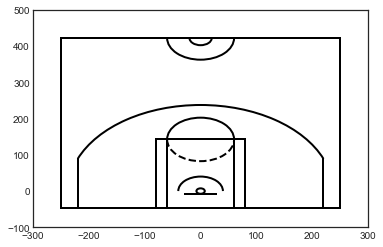

In [9]:
# Now We have a court to play on!
plt.figure()
draw_court(outer_lines=True)
plt.xlim(-300,300)
plt.ylim(-100,500)
plt.show()

### Shooting Around on Our Court - Scatter Plots

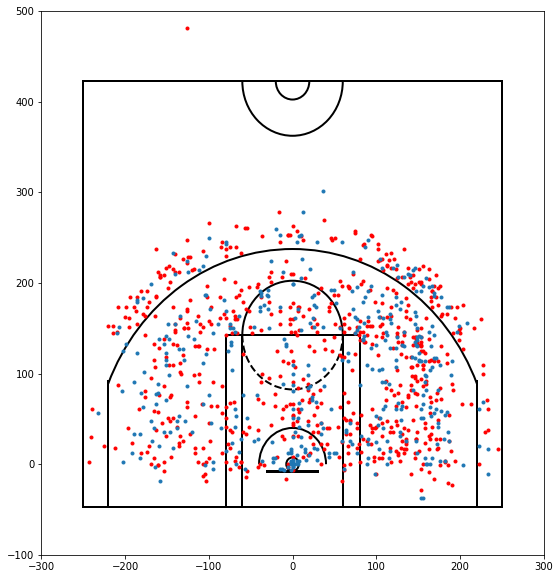

In [29]:
# We can plot Durant's shot attempts on the court
plt.figure(figsize = (9,10))

# Plot the court
draw_court(outer_lines = True)
plt.xlim(-300,300)
plt.ylim(-100,500)

# Plot the shots
plt.plot(Rookie_DF.loc[Rookie_DF.SHOT_MADE_FLAG == 0,'LOC_X'],
        Rookie_DF.loc[Rookie_DF.SHOT_MADE_FLAG == 0,'LOC_Y'], 'r.')
plt.plot(Rookie_DF.loc[Rookie_DF.SHOT_MADE_FLAG == 1,'LOC_X'],
        Rookie_DF.loc[Rookie_DF.SHOT_MADE_FLAG == 1,'LOC_Y'], '.')
plt.show()

Now we're getting somewhere!

### Joint Scatter Plots.

If you're following along with Savvas's tutorial we start to make our plots a little fancier. We can add histograms along the x and y axes to see the distributions of a player/team's shots. We do this with seaborn's `jointplot` function. To better understand it check out <a href = "https://seaborn.pydata.org/generated/seaborn.jointplot.html">the documentation</a>.

These are cool little plots that have plenty of options we'll check out what they can do through the rest of this section.

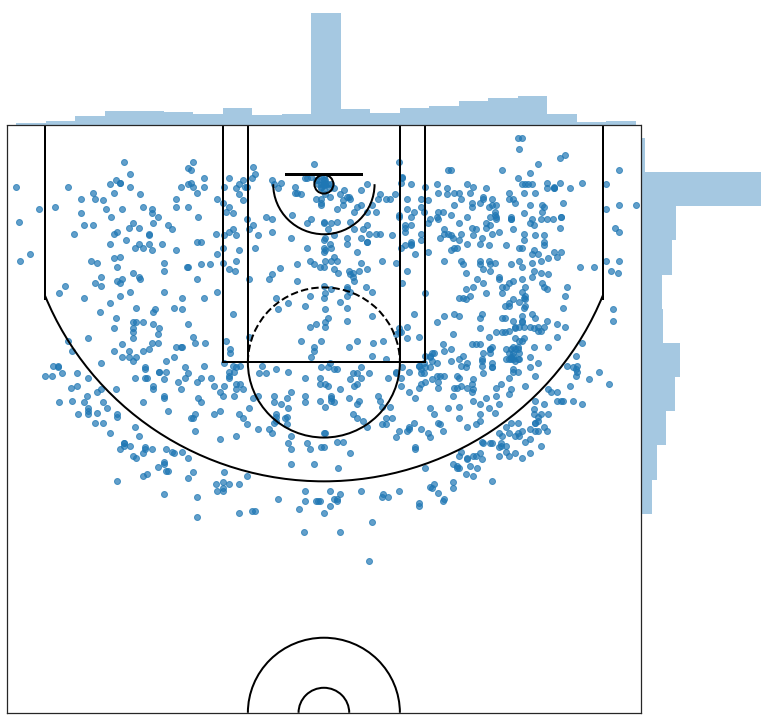

In [15]:
# Make the joint plot
JointChart = sns.jointplot(data = Rookie_DF, x = "LOC_X", y = "LOC_Y", 
                            stat_func = None, kind = 'scatter', space = 0, 
                            alpha = .7)

# Set the figure size
JointChart.fig.set_size_inches((12,11))

# joint plots have three ax, this one is where we want to plot the court.
Court = JointChart.ax_joint
draw_court(Court)

# Set the axis limits
Court.set_xlim(-250,250)
Court.set_ylim(422.5, -47.5)

# Turn off the labels and ticks
Court.tick_params(labelbottom = "off", labelleft = "off")
Court.set_xlabel('')
Court.set_ylabel('')



plt.show()

Our prettiest chart yet! Note this one is rotated. This is because the original data was shown to us how a viewer would see it. This means that what is labeled 'Right' is actually the player's left. If you're into Theatre think Stage Right versus actual Right. 

Our rotation allowed us to view the positioning as the players experience it.

Now let's try a chart where we produce a heat map of shots instead of points.

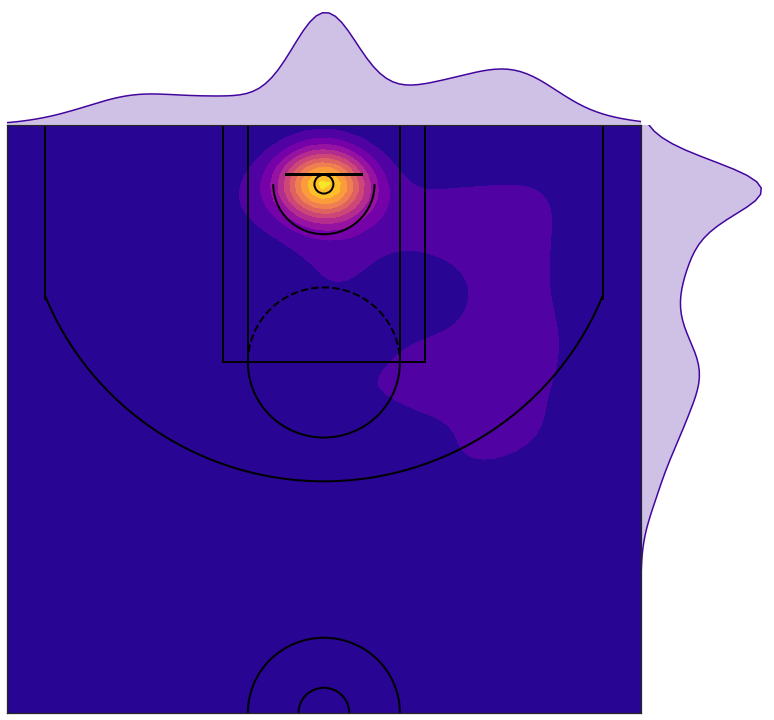

In [17]:
# Code is adapted from Savvas's

# This imports a color map from plt
cmap = plt.cm.plasma

# This makes our joinplot we've changed our kind variable to be
# 'kde' this means we want the density of the points.
JointChart = sns.jointplot(Rookie_DF.LOC_X, Rookie_DF.LOC_Y, stat_func=None,
                                 kind='kde', space=0, color=cmap(0.1),
                                 cmap=cmap, n_levels=10)

# Set the size of the figure
JointChart.fig.set_size_inches(12,11)

# Draw the court
Court = JointChart.ax_joint
draw_court(Court)

# rotate the court
Court.set_xlim(-250,250)
Court.set_ylim(422.5, -47.5)

# Eliminate labels and axis ticks
Court.set_xlabel('')
Court.set_ylabel('')
Court.tick_params(labelbottom='off', labelleft='off')

plt.show()

This chart is prettier and more informative than the last one. We retain the information from the scatter plot that Durant attempted many shots right under the basket (smart choice Kevin), but now we can see that he definitely prefers shooting from the right hand side of the court based on the lighter upside down L shape seen in the plot above.

This could provide actionable information for opposing teams. Perhaps if we would have forced Durant to go to the left side of the court more we could get the ball out of his lethal hands. 

That was great, but wait there's more! We can do what's called a hex plot as well. The idea behind a hex plot is pretty straightforward and in my opinion clever. We can visualize the distribution of 1-D data (i.e. a single variable) with a histogram. We saw this with the x and y coordinates with the joint scatter plot above. But in doing that we lose the inherent 2-D nature of the data (the (x,y) pairs). Enter the hex plot. In hex plots we tile the plane with hexagons. Then we look at how many points fall in each hexagon and assign it that number. Using another color scale we assign each hexagon a color based on its number. This leaves us with essentially a 2-D histogram.

Let's see what happens when we do this for Durant's Rookie Seaosn.